# Misc dataset

In [1]:
from model.graph_mcmc import Graph_MCMC

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
graph = Graph_MCMC()
graph.read_from_ns("polbooks") #"soc_net_comms/amazon"

In [4]:
graph.print_info()
graph.rename_property("label", "_label")

Graph with N=105 nodes, E=441 edges and D=2 vertex features for training


True

In [5]:

graph.convert_props_to_flags()

In [6]:
graph.list_props()

name            (graph)   (type: string, val: polbooks)
description     (graph)   (type: string, val: A network of books about U.S.
                                              politics published close to the
                                              2004 U.S. presidential election,
                                              and sold by Amazon.com. Edges
                                              between books represent frequent
                                              copurchasing of those books by
                                              the same buyers. The network was
                                              compiled by V. Krebs and is
                                              unpublished.)
citation        (graph)   (type: string, val: ['V. Krebs, unpublished,
                                              http://www.orgnet.com/,
                                              http://www.orgnet.com/'])
url             (graph)   (type: string, val: http://

In [7]:
graph.partition(B_min=3, B_max=3)

Performing inference...
Current bracket: (3, 3, 3) (1224.974997621506, 1224.974997621506, 1224.974997621506)
Current bracket: (3, 3, 3) (1224.974997621506, 1224.974997621506, 1224.974997621506)
Bisect at B = 3 with S = 1224.974997621506
Best result: B = 3, S = 1224.974997621506
Done


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f9e193711c0, at 0x7f9da8d8c9d0>

In [8]:
graph.mcmc(num_iter=10000)

100%|██████████| 10000/10000 [00:02<00:00, 3461.83it/s]


11.69809009083878

Drawing soft partition


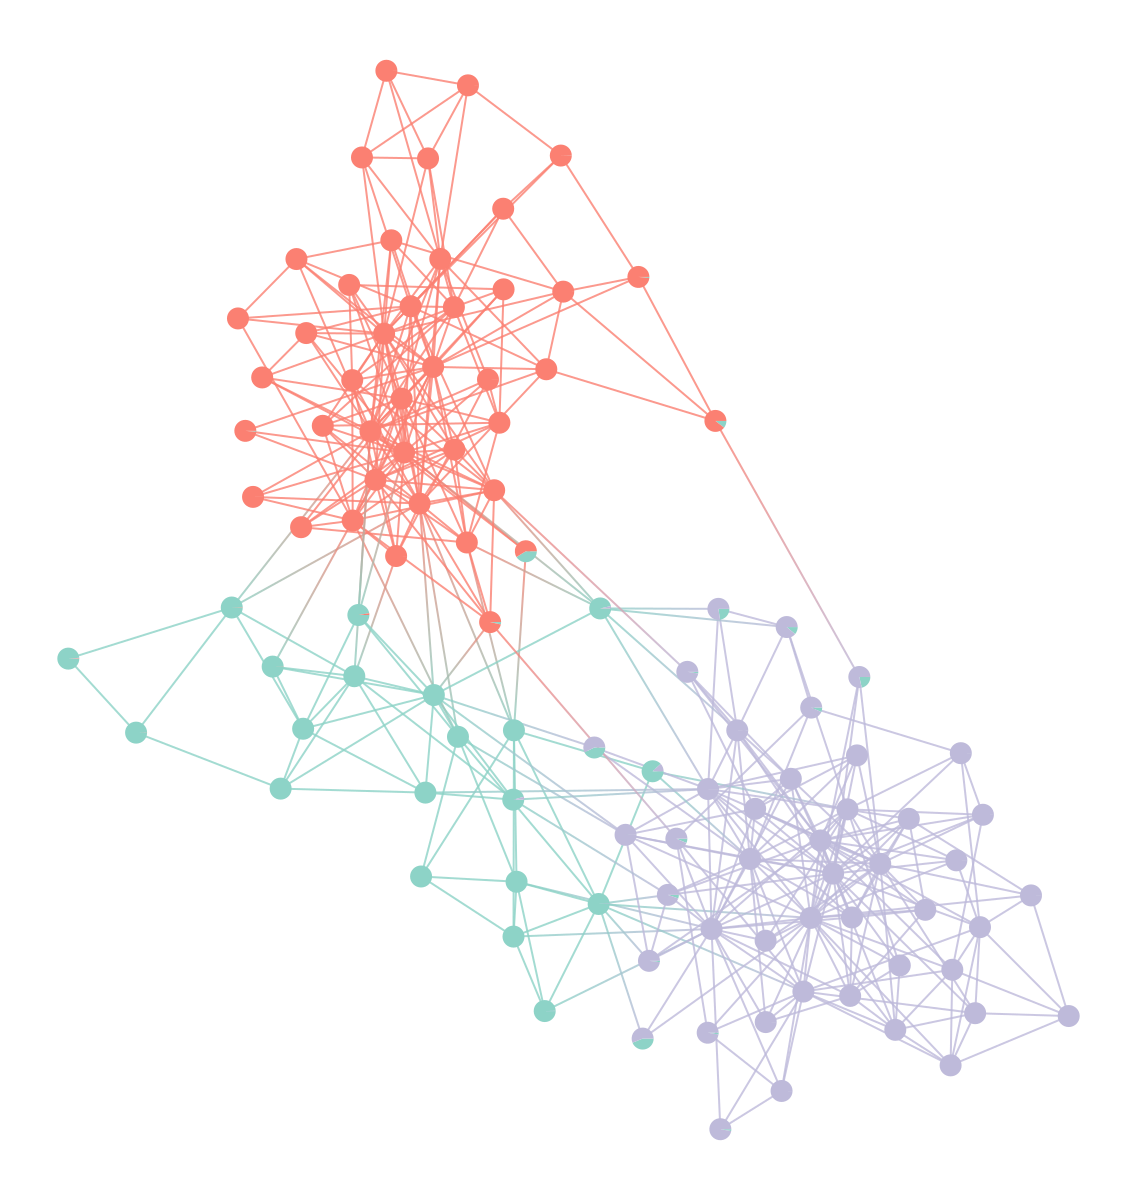

In [9]:
#graph.draw(gen_layout=False, size=10, output="polbooks-graph.png")
graph.draw(gen_layout=False, size=10)

Drawing block adjacency matrix $e_{rs}$


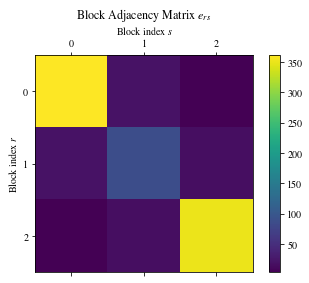

In [10]:
graph.plot_matrix()

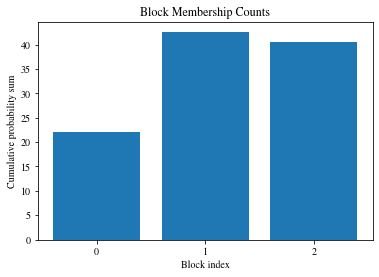

In [11]:
graph.plot_posterior_props()

## Train classifier

In [12]:
from inference.softmax import SoftmaxNeuralNet
import numpy as np

In [13]:
X = graph.generate_feature_matrix()
Y = graph.generate_posterior()

D = X.shape[1]
B = Y.shape[1]

N = X.shape[0]
assert N == Y.shape[0]



In [14]:
from utils.subsampling import random_index_arr

train_indices, test_indices = random_index_arr(N, fraction=0.8)
X_train, Y_train = X[train_indices, :], Y[train_indices, :]
X_test, Y_test = X[test_indices, :], Y[test_indices, :]

In [15]:
classifier = SoftmaxNeuralNet(layers_size=[D, B], sigma=1)
classifier.perform_mala(X_train, Y_train, step_scaling=0.1, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [00:09<00:00, 1082.93it/s]Sample accept ratio: 91.3%
Train. set accuracy: 85.71428571428571%



(0.913, 0.8571428571428571)

## Interpret results

### Thinning

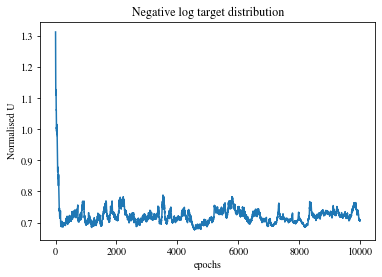

0.7215874692702602

In [16]:
classifier.plot_U()

In [17]:
classifier.thin_samples(burn_in_pc=20, thinning_pc=10)

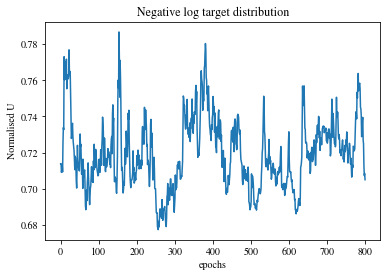

0.7195880646694282


In [18]:
u_mean = classifier.plot_U()
print(u_mean)

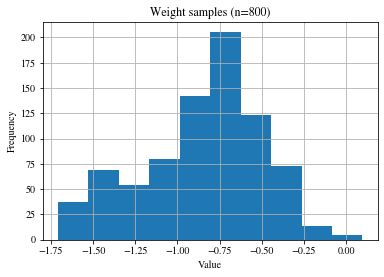

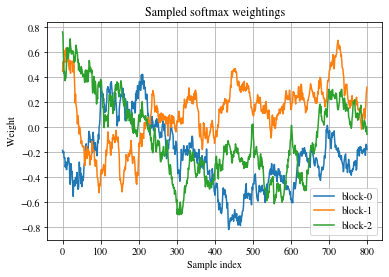

In [19]:
classifier.plot_sample_histogram()
classifier.plot_sample_history()

### Performance

In [20]:
training_loss = classifier.average_loss_per_point(X_train, Y_train, include_prior=False)
test_loss = classifier.average_loss_per_point(X_test, Y_test, include_prior=False)

print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))


Training loss: 0.5273658250095264, Test loss: 0.7355755016845021


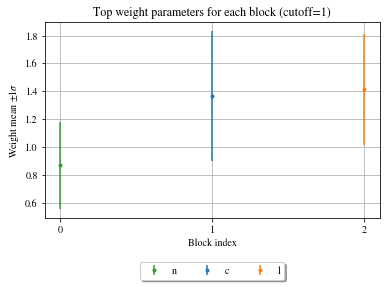

In [21]:
names = list(graph.get_feature_names())
classifier.plot_block_principal_dims(names, cutoff=1, legend=True)

Discarded 3 features


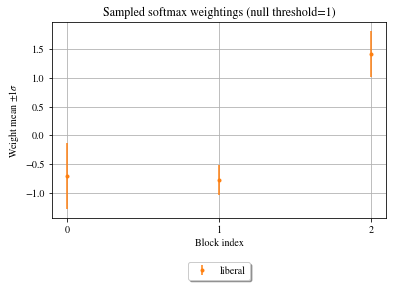

In [22]:
names = list(graph.get_feature_names())
names = ["conservative", "liberal", "neutral"]
kept_features = classifier.plot_sampled_weights(names, std_dev_multiplier=1, null_space=1, legend=True)

In [23]:
reduced_X_train, reduced_X_test = X_train[:, kept_features], X_test[:, kept_features]

reduced_D = reduced_X_train.shape[1]
B = Y_train.shape[1]

# nwo train new classifier
reduced_classifier = SoftmaxNeuralNet(layers_size=[reduced_D, B], sigma=1)
reduced_classifier.perform_mala(reduced_X_train, Y_train, step_scaling=0.1, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [00:08<00:00, 1213.40it/s]Sample accept ratio: 91.86999999999999%
Train. set accuracy: 79.76190476190477%



(0.9187, 0.7976190476190477)

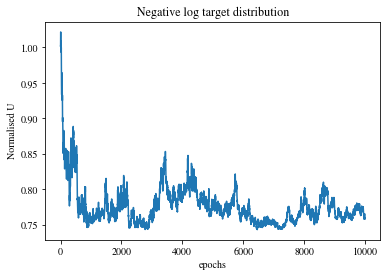

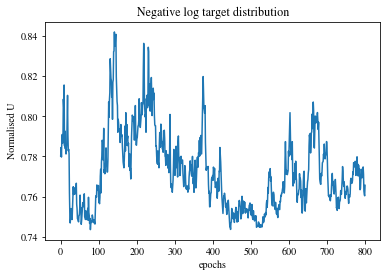

0.7726432587572312

In [24]:
reduced_classifier.plot_U()
reduced_classifier.thin_samples(burn_in_pc=20, thinning_pc=10)
reduced_classifier.plot_U()

In [25]:
reduced_training_loss = reduced_classifier.average_loss_per_point(reduced_X_train, Y_train, include_prior=False)
reduced_test_loss = reduced_classifier.average_loss_per_point(reduced_X_test, Y_test, include_prior=False)

print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

REDUCED CLASSIFIER -- Training loss: 0.6546198479045843, Test loss: 0.7649408596477908
